In [1]:
import numpy as np
import tensorflow as tf

from scipy import stats
from sklearn.metrics import r2_score
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns

# Data
from data.data_generator import data_generator
from data.data_generator import data_model
from data.data_filtering import (sanity_checks, est_sanity_checks, sample_sanity_checks)

# Model
from models.models import HeteroskedasticModel, SequenceNet
from models.models import BayesFlow

# Utils
from utils.losses import heteroskedastic_loss, maximum_likelihood_loss
from utils.training import train_step
from utils.viz import (plot_true_est_scatter, plot_true_est_posterior, 
                       plot_correlation_parameters, plot_comp_post_prior, plot_ppc)

%load_ext autoreload
%autoreload 2

In [2]:
# Using Heteroskedastic model as summary net
class SummaryNet(tf.keras.Model):
    def __init__(self, meta):
        super(CustomSummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|params)
        """
        
        # Do something with input
        return x

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'lstm_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
# parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\rho$']
parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\eta$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR_lstm"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [4]:
%%time
data_test = data_generator(n_test)

# Preprocessing untrained data
x_test = np.array(data_test['x'])
theta_test = np.array(data_test['theta'])

CPU times: user 147 ms, sys: 5.19 ms, total: 152 ms
Wall time: 148 ms


In [5]:
print(type(x_test))
print(x_test.shape)
print(type(theta_test))
print(theta_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks
x_test, theta_test = sanity_checks(x_test, theta_test)

# Sanity checks for numerical stability
assert(np.sum(x_test == np.inf) == 0)
assert(np.sum(x_test == -np.inf) == 0)
assert(np.sum(x_test == np.nan) == 0)

In [7]:
print(x_test.shape)
print(theta_test.shape)

(500, 100, 5)
(500, 5)


In [8]:
# Instantiate model
summary_net = SequenceNet()
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

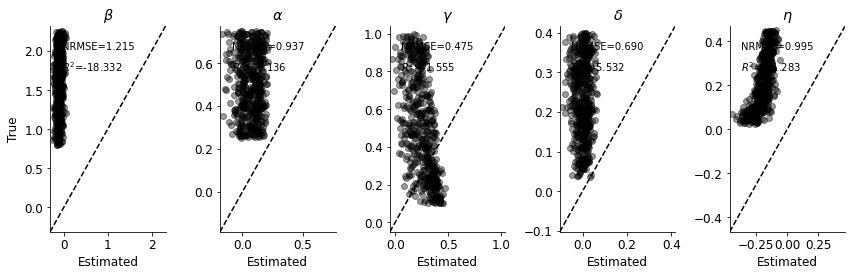

In [9]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, parameter_names, figsize=(12, 4))

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [11]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(model=model, 
                            optimizer=optimizer,
                            loss_fn=maximum_likelihood_loss, 
                            iterations=iterations_per_epoch,
                            batch_size=batch_size,
                            p_bar=p_bar,
                            global_step=global_step) 

        # Manage checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (64, 500)